CSC with a Spatial Mask
=======================

This example demonstrates the use of [cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) for convolutional sparse coding with a spatial mask [[29]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-boundary). The example problem is inpainting of randomly distributed corruption of a colour image [[30]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional).

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdn
from sporco import util
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()

Load a reference image.

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 idxexp=np.s_[:, 160:672])

Create random mask and apply to reference image to obtain test image. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
t = 0.5
np.random.seed(12345)
msk = np.random.randn(*(img.shape))
msk[np.abs(msk) > t] = 1;
msk[np.abs(msk) < t] = 0;
imgw = msk * img

Define pad and crop functions.

In [4]:
pn = 8
spad = lambda x:  np.pad(x, ((pn, pn), (pn, pn), (0, 0)), mode='symmetric')
zpad = lambda x:  np.pad(x, ((pn, pn), (pn, pn), (0, 0)), mode='constant')
crop = lambda x: x[pn:-pn, pn:-pn]

Construct padded mask and test image.

In [5]:
mskp = zpad(msk)
imgwp = spad(imgw)

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter. The highpass component is the difference between the test image and the lowpass component, multiplied by the mask for faster convergence of the convolutional sparse coding (see [[39]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2017-convolutional3)).

In [6]:
lmbda = 0.05
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
                    'DFidWeight': mskp, 'gEvalY': False,
                    'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(imgwp, lmbda, opt, caxis=2)
sl = b.solve()
sh = mskp * (imgwp - sl)

Load dictionary.

In [7]:
D = util.convdicts()['RGB:8x8x3x64']

Set up [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) options.

In [8]:
lmbda = 2e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                    'HighMemSolve': True, 'RelStopTol': 5e-3,
                    'AuxVarObj': False, 'RelaxParam': 1.8,
                    'rho': 5e1*lmbda + 1e-1, 'AutoRho': {'Enabled': False,
                    'StdResiduals': False}})

Construct [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) wrapper for [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) and solve via wrapper. This example could also have made use of [admm.cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl), which has similar performance in this application, but [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) has the advantage of greater flexibility in that the wrapper can be applied to a variety of CSC solver objects.

In [9]:
ams = cbpdn.AddMaskSim(cbpdn.ConvBPDN, D, sh, mskp, lmbda, opt=opt)
X = ams.solve()

Itn   Fnc       DFid      Regℓ1     r         s         
------------------------------------------------------


   0  3.48e+01  2.00e+00  1.64e+03  9.53e-01  5.85e-01


   1  3.22e+01  3.91e+00  1.42e+03  3.77e-01  5.53e-01


   2  2.82e+01  2.57e+00  1.28e+03  2.18e-01  2.62e-01


   3  2.61e+01  2.28e+00  1.19e+03  1.64e-01  1.78e-01


   4  2.51e+01  2.21e+00  1.14e+03  1.38e-01  1.36e-01


   5  2.43e+01  2.22e+00  1.11e+03  1.21e-01  1.09e-01


   6  2.34e+01  2.26e+00  1.06e+03  1.08e-01  9.33e-02


   7  2.25e+01  2.32e+00  1.01e+03  9.80e-02  8.13e-02


   8  2.17e+01  2.38e+00  9.68e+02  8.95e-02  7.24e-02


   9  2.11e+01  2.45e+00  9.33e+02  8.22e-02  6.52e-02


  10  2.06e+01  2.51e+00  9.05e+02  7.59e-02  5.90e-02


  11  2.02e+01  2.57e+00  8.82e+02  7.05e-02  5.36e-02


  12  1.98e+01  2.63e+00  8.58e+02  6.55e-02  4.88e-02


  13  1.93e+01  2.67e+00  8.33e+02  6.11e-02  4.49e-02


  14  1.88e+01  2.72e+00  8.05e+02  5.72e-02  4.19e-02


  15  1.83e+01  2.76e+00  7.78e+02  5.36e-02  3.91e-02


  16  1.79e+01  2.80e+00  7.54e+02  5.04e-02  3.64e-02


  17  1.75e+01  2.84e+00  7.34e+02  4.76e-02  3.39e-02


  18  1.72e+01  2.87e+00  7.16e+02  4.50e-02  3.17e-02


  19  1.69e+01  2.90e+00  7.01e+02  4.26e-02  2.98e-02


  20  1.67e+01  2.93e+00  6.88e+02  4.04e-02  2.79e-02


  21  1.65e+01  2.95e+00  6.76e+02  3.84e-02  2.61e-02


  22  1.63e+01  2.97e+00  6.65e+02  3.65e-02  2.45e-02


  23  1.60e+01  2.99e+00  6.53e+02  3.47e-02  2.31e-02


  24  1.58e+01  3.00e+00  6.40e+02  3.30e-02  2.21e-02


  25  1.56e+01  3.02e+00  6.28e+02  3.15e-02  2.11e-02


  26  1.54e+01  3.03e+00  6.18e+02  3.01e-02  2.01e-02


  27  1.52e+01  3.05e+00  6.08e+02  2.87e-02  1.91e-02


  28  1.51e+01  3.06e+00  6.00e+02  2.75e-02  1.82e-02


  29  1.49e+01  3.07e+00  5.91e+02  2.64e-02  1.74e-02


  30  1.47e+01  3.08e+00  5.83e+02  2.53e-02  1.66e-02


  31  1.46e+01  3.09e+00  5.76e+02  2.42e-02  1.59e-02


  32  1.45e+01  3.09e+00  5.69e+02  2.33e-02  1.52e-02


  33  1.43e+01  3.10e+00  5.62e+02  2.24e-02  1.46e-02


  34  1.42e+01  3.11e+00  5.56e+02  2.15e-02  1.40e-02


  35  1.41e+01  3.11e+00  5.50e+02  2.08e-02  1.34e-02


  36  1.40e+01  3.12e+00  5.45e+02  2.00e-02  1.28e-02


  37  1.39e+01  3.13e+00  5.39e+02  1.93e-02  1.23e-02


  38  1.38e+01  3.13e+00  5.34e+02  1.86e-02  1.19e-02


  39  1.37e+01  3.14e+00  5.29e+02  1.80e-02  1.15e-02


  40  1.36e+01  3.14e+00  5.24e+02  1.73e-02  1.12e-02


  41  1.35e+01  3.14e+00  5.20e+02  1.68e-02  1.08e-02


  42  1.35e+01  3.15e+00  5.16e+02  1.62e-02  1.05e-02


  43  1.34e+01  3.15e+00  5.12e+02  1.57e-02  1.01e-02


  44  1.33e+01  3.16e+00  5.08e+02  1.52e-02  9.76e-03


  45  1.33e+01  3.16e+00  5.05e+02  1.48e-02  9.44e-03


  46  1.32e+01  3.17e+00  5.01e+02  1.43e-02  9.13e-03


  47  1.31e+01  3.17e+00  4.98e+02  1.39e-02  8.84e-03


  48  1.31e+01  3.17e+00  4.94e+02  1.35e-02  8.57e-03


  49  1.30e+01  3.18e+00  4.91e+02  1.31e-02  8.30e-03


  50  1.29e+01  3.18e+00  4.88e+02  1.27e-02  8.02e-03


  51  1.29e+01  3.18e+00  4.85e+02  1.24e-02  7.75e-03


  52  1.28e+01  3.18e+00  4.82e+02  1.20e-02  7.51e-03


  53  1.28e+01  3.19e+00  4.80e+02  1.17e-02  7.28e-03


  54  1.27e+01  3.19e+00  4.77e+02  1.14e-02  7.06e-03


  55  1.27e+01  3.19e+00  4.75e+02  1.11e-02  6.87e-03


  56  1.26e+01  3.19e+00  4.72e+02  1.08e-02  6.69e-03


  57  1.26e+01  3.20e+00  4.70e+02  1.05e-02  6.52e-03


  58  1.26e+01  3.20e+00  4.68e+02  1.02e-02  6.34e-03


  59  1.25e+01  3.20e+00  4.66e+02  9.97e-03  6.17e-03


  60  1.25e+01  3.20e+00  4.64e+02  9.73e-03  5.99e-03


  61  1.24e+01  3.20e+00  4.62e+02  9.49e-03  5.82e-03


  62  1.24e+01  3.20e+00  4.60e+02  9.26e-03  5.66e-03


  63  1.24e+01  3.21e+00  4.58e+02  9.04e-03  5.51e-03


  64  1.23e+01  3.21e+00  4.56e+02  8.82e-03  5.38e-03


  65  1.23e+01  3.21e+00  4.54e+02  8.61e-03  5.25e-03


  66  1.23e+01  3.21e+00  4.53e+02  8.41e-03  5.13e-03


  67  1.22e+01  3.21e+00  4.51e+02  8.21e-03  5.02e-03


  68  1.22e+01  3.21e+00  4.49e+02  8.02e-03  4.91e-03


  69  1.22e+01  3.21e+00  4.47e+02  7.84e-03  4.80e-03


  70  1.21e+01  3.22e+00  4.46e+02  7.67e-03  4.70e-03


  71  1.21e+01  3.22e+00  4.44e+02  7.50e-03  4.60e-03


  72  1.21e+01  3.22e+00  4.43e+02  7.33e-03  4.50e-03


  73  1.20e+01  3.22e+00  4.41e+02  7.18e-03  4.41e-03


  74  1.20e+01  3.22e+00  4.40e+02  7.02e-03  4.32e-03


  75  1.20e+01  3.22e+00  4.39e+02  6.88e-03  4.23e-03


  76  1.20e+01  3.22e+00  4.37e+02  6.74e-03  4.14e-03


  77  1.19e+01  3.22e+00  4.36e+02  6.60e-03  4.06e-03


  78  1.19e+01  3.22e+00  4.35e+02  6.47e-03  3.98e-03


  79  1.19e+01  3.23e+00  4.34e+02  6.34e-03  3.89e-03


  80  1.19e+01  3.23e+00  4.33e+02  6.22e-03  3.81e-03


  81  1.19e+01  3.23e+00  4.32e+02  6.10e-03  3.74e-03


  82  1.18e+01  3.23e+00  4.31e+02  5.98e-03  3.67e-03


  83  1.18e+01  3.23e+00  4.29e+02  5.87e-03  3.60e-03


  84  1.18e+01  3.23e+00  4.28e+02  5.75e-03  3.53e-03


  85  1.18e+01  3.23e+00  4.27e+02  5.65e-03  3.47e-03


  86  1.18e+01  3.23e+00  4.27e+02  5.54e-03  3.40e-03


  87  1.17e+01  3.23e+00  4.26e+02  5.44e-03  3.34e-03


  88  1.17e+01  3.23e+00  4.25e+02  5.35e-03  3.28e-03


  89  1.17e+01  3.23e+00  4.24e+02  5.25e-03  3.22e-03


  90  1.17e+01  3.23e+00  4.23e+02  5.16e-03  3.16e-03


  91  1.17e+01  3.23e+00  4.22e+02  5.08e-03  3.10e-03


  92  1.17e+01  3.23e+00  4.21e+02  4.99e-03  3.05e-03
------------------------------------------------------


Reconstruct from representation.

In [10]:
imgr = crop(sl + ams.reconstruct().squeeze())

Display solve time and reconstruction performance.

In [11]:
print("AddMaskSim wrapped ConvBPDN solve time: %.2fs" %
      ams.timer.elapsed('solve'))
print("Corrupted image PSNR: %5.2f dB" % metric.psnr(img, imgw))
print("Recovered image PSNR: %5.2f dB" % metric.psnr(img, imgr))

AddMaskSim wrapped ConvBPDN solve time: 118.71s
Corrupted image PSNR: 11.68 dB
Recovered image PSNR: 31.58 dB


Display reference, test, and reconstructed image

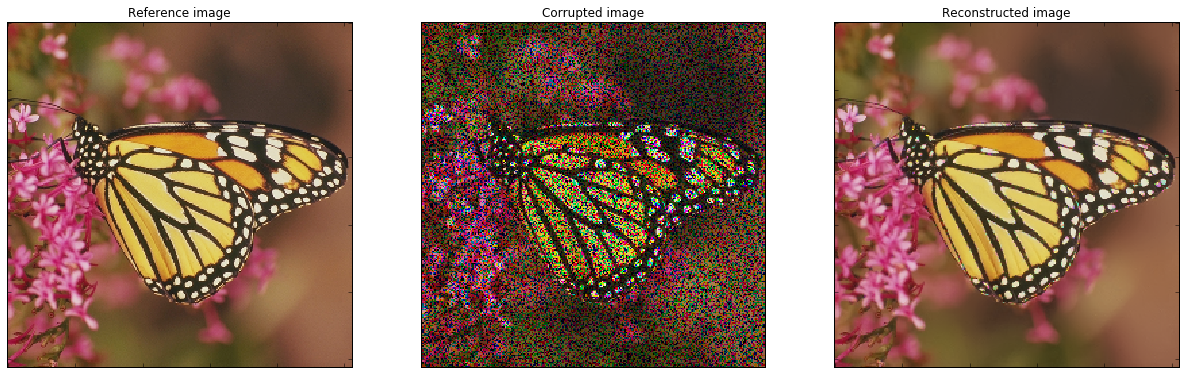

In [12]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, fig=fig, title='Reference image')
plot.subplot(1, 3, 2)
plot.imview(imgw, fig=fig, title='Corrupted image')
plot.subplot(1, 3, 3)
plot.imview(imgr, fig=fig, title='Reconstructed image')
fig.show()

Display lowpass component and sparse representation

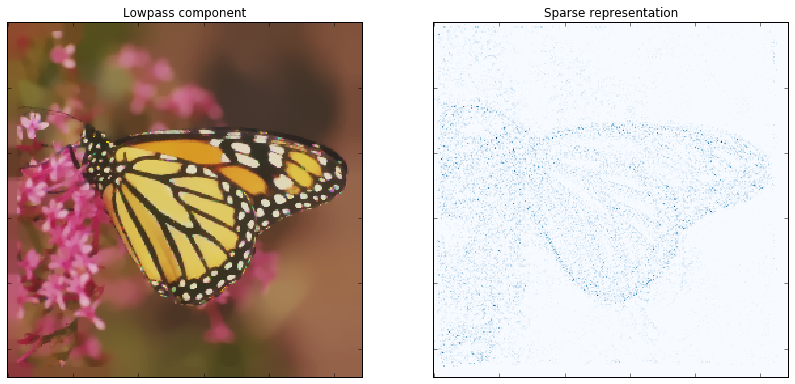

In [13]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(sl, fig=fig, cmap=plot.cm.Blues, title='Lowpass component')
plot.subplot(1, 2, 2)
plot.imview(np.squeeze(np.sum(abs(X), axis=ams.cri.axisM)), fig=fig,
            cmap=plot.cm.Blues, title='Sparse representation')
fig.show()

Plot functional value, residuals, and rho

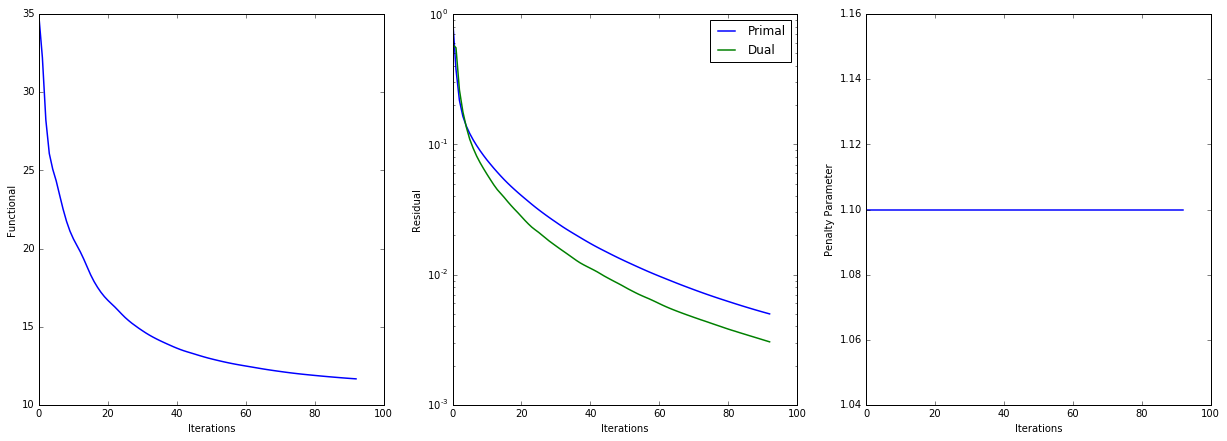

In [14]:
its = ams.getitstat()
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, fig=fig, xlbl='Iterations', ylbl='Functional')
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T, fig=fig,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.subplot(1, 3, 3)
plot.plot(its.Rho, fig=fig, xlbl='Iterations', ylbl='Penalty Parameter')
fig.show()